# Прогнозирование оттока и кластеризация клиентов сети фитнес-центров

## Описание проекта

Необходимо проанализировать данные посещения сети фитнес-центров, проанализировать основные признаки, наиболее сильно влияющие на отток, на основе данных подготовить модель для прогнозирования вероятности оттока (на уровне следующего месяца) для каждого клиента, сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами: выделить целевые группы клиентов, предложить меры по снижению оттока, определить другие особенности взаимодействия с клиентами.

## Описание данных

Набор данных включает следующие поля:
Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

## Оглавление<a class='anchor' id='TOC'></a>

* **[I. Подготовка к анализу](#1)**
* **[2. Исследовательский анализ данных](#2)**
* **[3. Кластеризация клиентов и подготовка данных для обучения модели](#3)**
* **[4. Обучение модели](#4)**
* **[Рекомендации](#conclusions)**
<br></br>

## 1. Подготовка к анализу<a class='anchor' id='1'></a>

#### - импортируем необходимые библиотеки и модули

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, f1_score,
                             precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.utils import shuffle
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
np.random.seed(42)

%matplotlib inline

Зафиксируем случайные числа:

In [2]:
np.random.seed(42)

Определим полезный класс и функции для дальнейшего анализа

In [3]:
class BasicInfo:
    """Выводим базовую информацию о датасете."""

    def __init__(self, data):
        self.data = data

    def get_info(self):
        """Получаем базовую информацию о таблице."""

        length = len(self.data)
        # Получаем типы данных и считаем пропуски
        types = pd.DataFrame(self.data.dtypes)
        nulls = pd.DataFrame(self.data.count())

        # Объединяем типы и пропуски, переименовываем колонки
        info = pd.concat([types, nulls], axis=1).reset_index()
        info.columns = ['Column', 'Dtype', 'Non-Null Count']

        # Считаем процент пропусков
        info['% of nulls'] = (100 -
                              round(info['Non-Null Count'] / length * 100, 2))

        return info

    def get_describe(self):
        """Считаем описательную статистику."""
        describes = self.data.describe().fillna('---').T
        return describes

    def basic_info_printer(self):
        """Выводим первые и пооследние пять строк, 
        базовую информацию, статистику."""

        # Получаем базовую информацию
        info = self.get_info()

        # Получаем базовую статистику
        describes = self.get_describe()

        display('Пять первых и последних строк', self.data,
                'Общая информация о датасете', info,
                'Описательная статистика', describes)


def sorted_corr(data, attr):
    """Выводим коэффициент корреляции для заданного признака."""
    correlated = pd.DataFrame(data.corr()[attr].sort_values(ascending=False))
    return correlated


def simple_grouper(data, grouper, agg_dict={'id': 'count'}):
    """Группируем данные, считаем процентное отношение."""
    data = data.groupby(grouper).agg(agg_dict).reset_index()
    if 'id' in agg_dict.keys():
        data['percent'] = round(data['id'] * 100 / data['id'].sum(), 2)
        data = data.sort_values(by='id', ascending=False)
    return data


## 2. Исследовательский анализ данных<a class='anchor' id='2'></a>

#### - прочитаем данные

In [4]:
df = pd.read_csv('datasets/gym_churn.csv')

#### - выведем первые пять первых и последних строк таблицы , общую информацию, статиcтику

In [5]:
reader = BasicInfo(df)

In [6]:
reader.basic_info_printer()

'Пять первых и последних строк'

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


'Общая информация о датасете'

,Column,Dtype,Non-Null Count,% of nulls
0,gender,int64,4000,0.0
1,Near_Location,int64,4000,0.0
2,Partner,int64,4000,0.0
3,Promo_friends,int64,4000,0.0
4,Phone,int64,4000,0.0
5,Contract_period,int64,4000,0.0
6,Group_visits,int64,4000,0.0
7,Age,int64,4000,0.0
8,Avg_additional_charges_total,float64,4000,0.0
9,Month_to_end_contract,float64,4000,0.0


'Описательная статистика'

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


В датасете 4 000 строк, без пропусков. Нет проблем с типами данных. Временных признаков в датасете нет, дубликатов нет. Не усматривается необычных и странных значений, датасет выглядит "игрушечным", подготовленным для обучения, категориальные признаки преобразованы в бинарные.

#### - проверим наличие полных дубликатов

In [7]:
(df.duplicated() == True).sum()

0

Полных дубликатов нет.

#### - проверим уникальные значения

In [8]:
df.nunique()

gender                                  2
Near_Location                           2
Partner                                 2
Promo_friends                           2
Phone                                   2
Contract_period                         3
Group_visits                            2
Age                                    23
Avg_additional_charges_total         4000
Month_to_end_contract                  12
Lifetime                               29
Avg_class_frequency_total            3913
Avg_class_frequency_current_month    3820
Churn                                   2
dtype: int64

Большинство признаков - категориальные, в целом ничего особенно интересного.

#### - ознакомимся с признаками, проверим баланс целевого признака

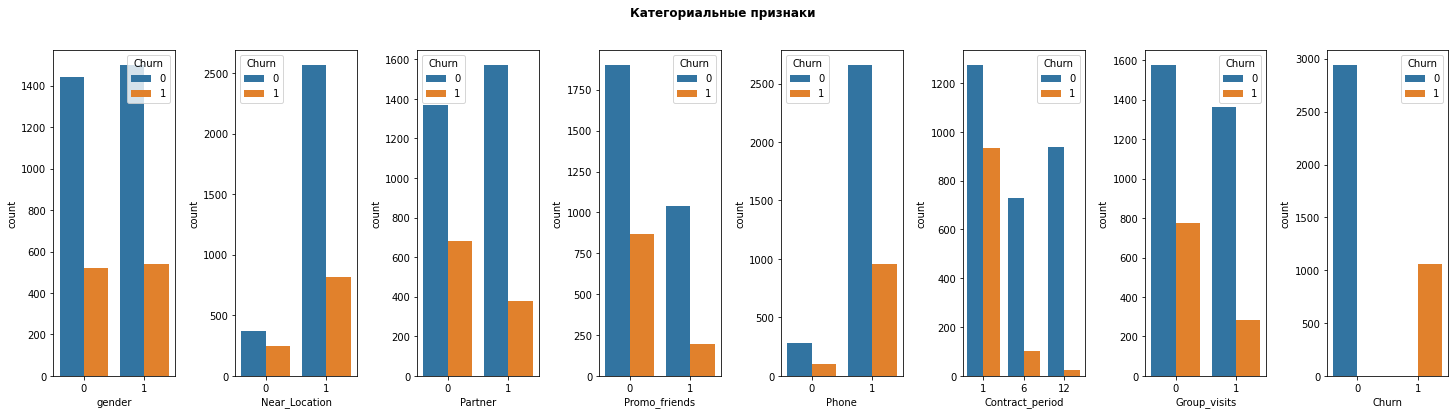

In [9]:
# отберем категориальные признаки
category_features = df.nunique().reset_index()
category_features = category_features[category_features[0] < 4]
category_features = category_features.drop(0, axis=1)

# вычислим размер полученной выборки
length = len(category_features)

# визуализируем признаки
_, ax = plt.subplots(1, length, figsize=(25, 6))
plt.subplots_adjust(wspace=0.5)
for idx in range(length):
    feature = category_features.iloc[idx, 0]
    sns.countplot(x=feature, hue='Churn', data=df, ax=ax[idx])
plt.text(-12, 3400, 'Категориальные признаки', fontsize=12, fontweight='bold');

Построим попарное распределение некатегориальных признаков:

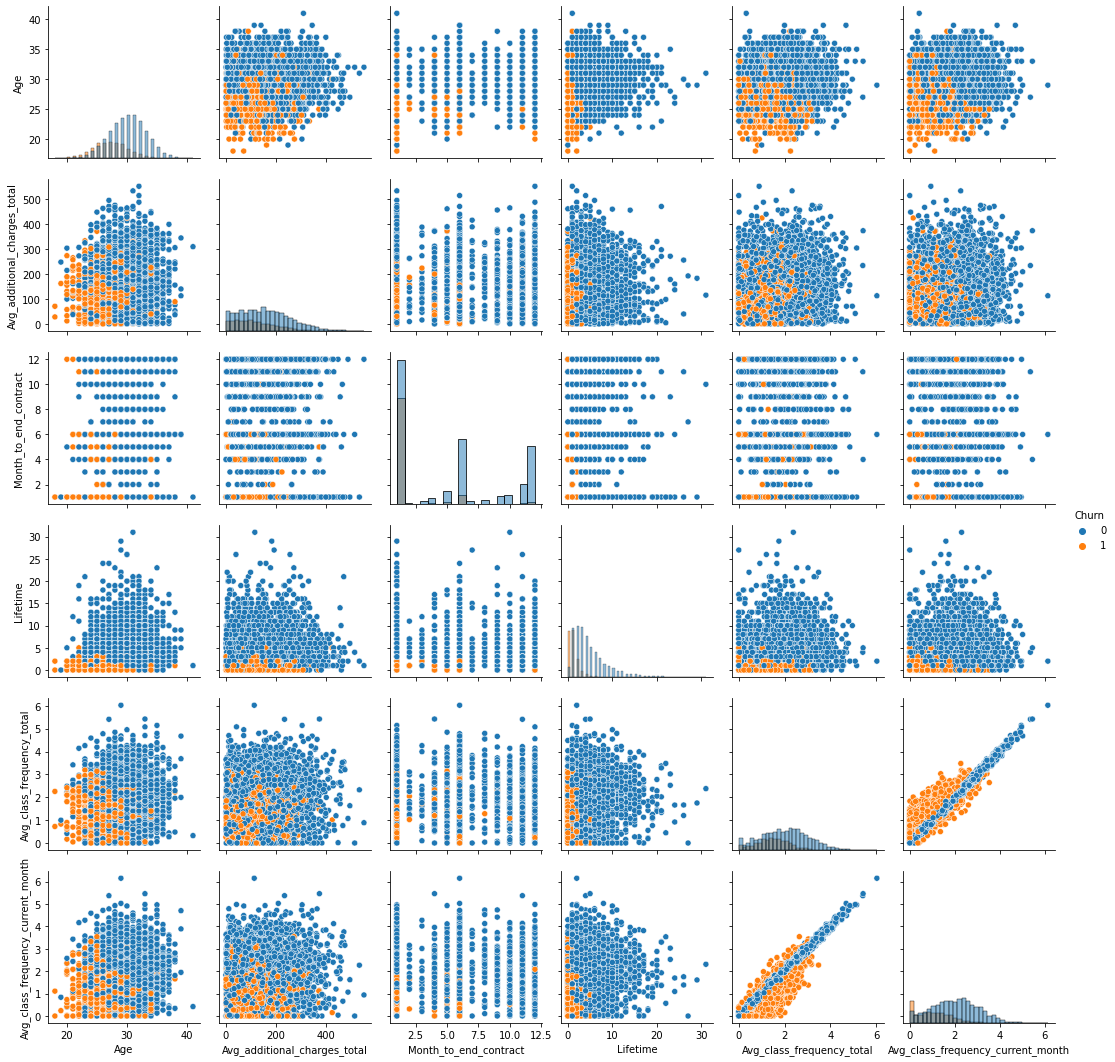

In [10]:
not_categorical = df.drop(category_features.drop(13)['index'].values, axis=1)
sns.pairplot(not_categorical, hue='Churn', diag_kind='hist');

1. Пол клиента, по всей видимости, не влияет на отток.
2. На графиках хорошо видно, что чем длинее срок контракта, тем меньше доля оттока. 
3. Расположение, рефферальное участие через друга, групповые визиты влияют не так значительно как срок контракта.
4. В датасете есть дисбаланс целевого признака в пропорции 1 к 3, что вряд ли должно существенно сказаться на модели.
5. Усматривается линейные зависимости между частотой посещений в неделю за полследний месяц и частотой посещений в неделю.

#### - Построим матрицу корреляций

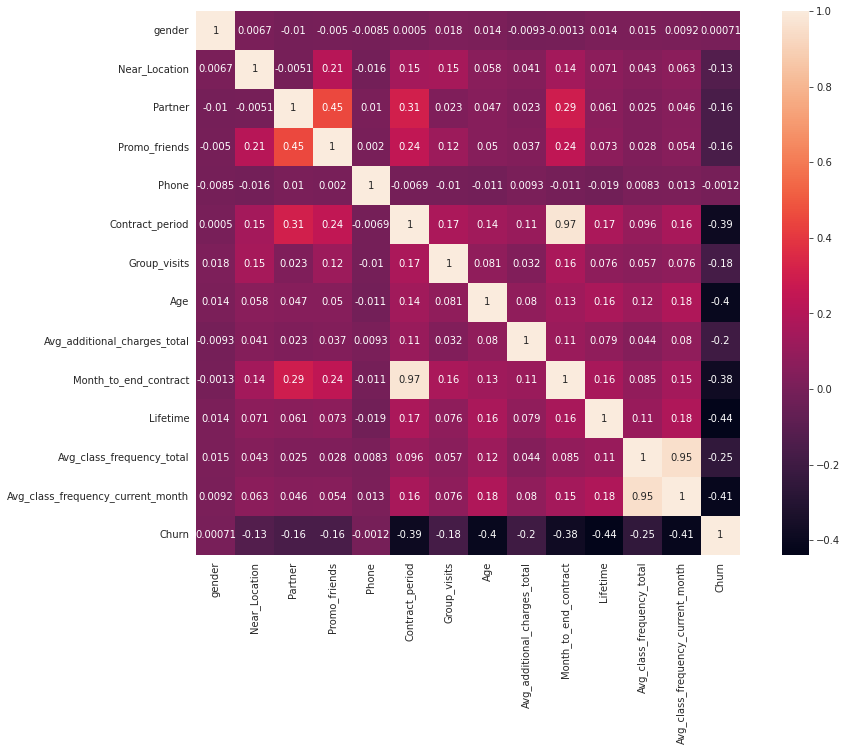

In [11]:
cm = df.corr()
sns.set_style('whitegrid')
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, square=True);

В датасете есть мультиколлинеарность между признками 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента и 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц, а также 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год) и 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах). 

**Мультиколлинеарность, в принципе, может оказать влияние на логистическую регрессию, но поскольку по умолчанию в модели применяется регуляризация (L2), а также принимая во внимание, что мы будем обучать и другие модели с кросс-валидацией на пяти фолдах - влияние мультиколлинеарности будет в значительной степени нивелировано, специально бороться с ним ценой исключения признаков на данном этапе нецелесообразно.** 

Дополнительно отдельно проверим корреляцию с целевым признаком:

In [12]:
sorted_corr(df, 'Churn')

,Churn
Churn,1.000000
gender,0.000708
Phone,-0.001177
Near_Location,-0.128098
Partner,-0.157986
Promo_friends,-0.162233
Group_visits,-0.175325
Avg_additional_charges_total,-0.198697
Avg_class_frequency_total,-0.249715
Month_to_end_contract,-0.381393


Относительно высокая отрицательная корреляция между целевым признаком и временем с момента первого обращения в фитнес-центр (в месяцах), средней частотой посещений в неделю за предыдущий месяц, возрастом, длительностью текущего действующего абонемента, срока до окончания текущего действующего абонемента: чем дольше клиент ходит и чем больше потратил на абонемент - тем дольше он возвращается.

#### - проверим средние значения признаков в двух группах

In [13]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


&#9889; **Выводы:**

1. В датасете 4 000 строк, без пропусков.
2. Нет проблем с типами данных.
3. Временных признаков в датасете нет, дубликатов нет.
4. Не усматривается необычных и странных значений, "игрушечный" датасет, подготовленный для обучения, категориальные признаки преобразованы в бинарные.
5. В датасете усматривается мультиколлинеарность между несколькими признаками, что может оказать влияние на логистическую регрессию, но поскольку мы будем обучать и другие модели, а также принимая во внимание, что обучение будет проходить с кросс-валидацией на пяти фолдах - влияние мультиколлинеарности будет нивелировано, специально бороться с ним ценой исключения признаков на данном этапе нецелесообразно.
6. Столбец Phone и gender - кандидаты на удаление, поскольку нерелевантны по отношению к целевому признаку, не является универсальными признаками.
7. Средний возраст клиента - двадцать девять лет, средний срок абонемента - почти пять месяцев, чуть менее половины клиентов посещают групповые занятия, и, в среднем, менее двух раз в неделю посещают центр.
8. Ушедшие клиенты младше, с более коротким периодом договора, вдое реже участвуют в групповых занятия и, в целом, реже посещали центры.

[В оглавление](#TOC)

## 3. Кластеризация клиентов и подготовка данных для обучения модели<a class='anchor' id='3'></a>

#### - исключим из признаков сведения о гендере и контактном телефоне, стандартизируем данные

Ранее было установлено, что пол и контактный телефон слабо коррелирует с целевым признаком. На данном этапе, исключим данные признаки как шум:

In [14]:
df_for_models = df.copy().drop(['gender', 'Phone'], axis=1)

Стандартизируем признаки

In [15]:
scaler = StandardScaler()
X_without_churn = scaler.fit_transform(df_for_models.drop('Churn', axis=1))

#### - дендограмма

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму:

In [16]:
linked = linkage(X_without_churn, method='ward') 

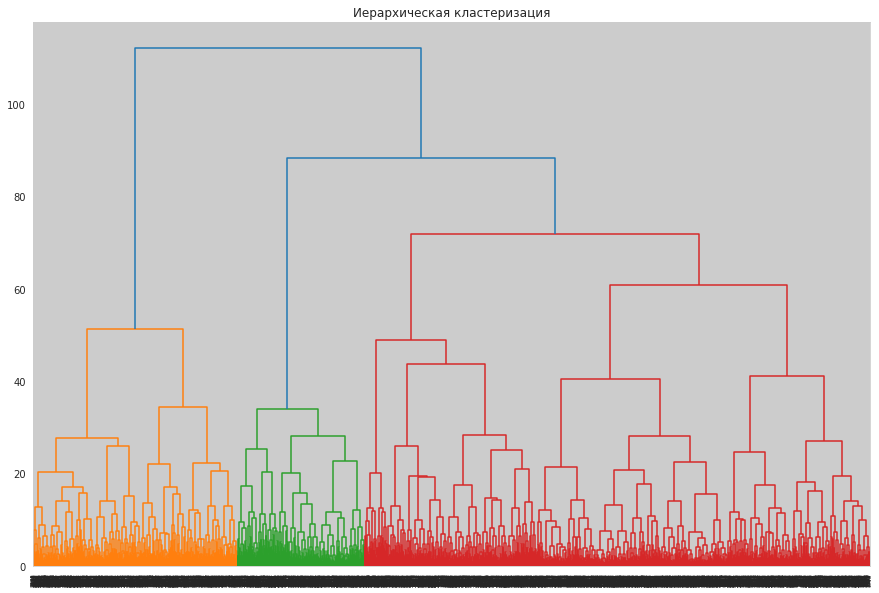

In [17]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 

Предложенное оптимальное число кластеров 3 — три разных цвета на графике.

#### - посчитаем оптимальное число кластеров для модели методом локтя 

Чтобы улучшить данные для моделей добавим признаки, основанные на кластерах - самый простой и быстрый способ получить дополнительные признаки. Поскольку мы хотим получить воспроизводимый результат на новых данных без целевого признака, выделим кластеры на данных без целевого признака. Дополнительно определим оптимальное число кластеров методом локтя, но **поскольку в настоящем случае нет оснований считать, что данные распределены нормально - используем не стандартизацию, которая предполагает нормальное распределение, а нормализацию для скалирования признаков, что должно дать иной результат при кластеризации**.

In [18]:
normalizer = Normalizer()

In [19]:
data_for_elbow = normalizer.fit_transform(df.drop('Churn', axis=1))

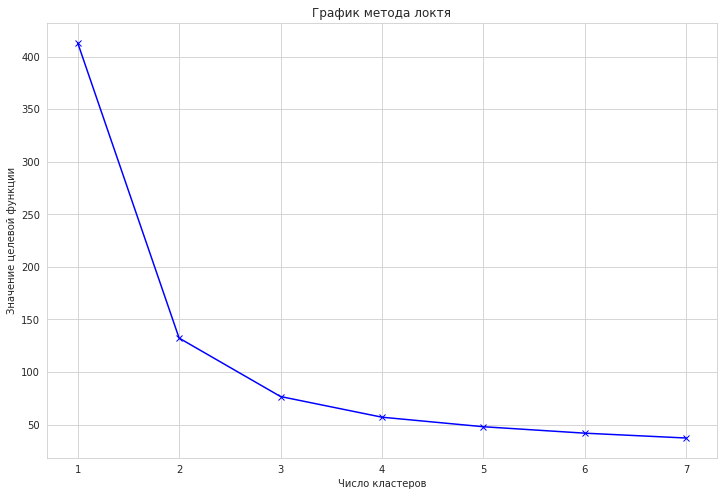

In [20]:
# сохраним значения целевой функции - суммы внутрикластерных отклонений
distortion = []

# зададим список с числом кластеров
K = range(1, 8)

# обучим модель для разного числа кластеров
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(data_for_elbow)
    distortion.append(model.inertia_)

# отобразим полученный список на графике
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.title('График метода локтя')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show() 

&#9889; **Выводы:**
момент перехода на плато отражает оптимальное количество кластеров. На графике плато начинается после третьего кластера. Таким образом, зададим число кластеров равное трем.

#### - определим кластеры и посчитаем средние значения признаков для каждого кластера

Обучаем модель и получаем кластеры

In [21]:
km = KMeans(n_clusters=3, random_state=42)
labels = km.fit_predict(X_without_churn)
df_for_models['cluster'] = labels

Считаем средние значения признаков для каждого кластера

In [22]:
mean_stat = df_for_models.groupby('cluster').mean()
mean_stat.columns = mean_stat.columns + '_mean'
mean_stat

,Near_Location_mean,Partner_mean,Promo_friends_mean,Contract_period_mean,Group_visits_mean,Age_mean,Avg_additional_charges_total_mean,Month_to_end_contract_mean,Lifetime_mean,Avg_class_frequency_total_mean,Avg_class_frequency_current_month_mean,Churn_mean
cluster,,,,,,,,,,,,
0,0.758600,0.380835,0.184275,1.874079,0.292383,28.066339,128.119345,1.783784,2.238943,1.214222,0.954207,0.565111
1,0.868376,0.340171,0.217094,2.417094,0.445299,30.013675,157.277770,2.253846,4.806838,2.715286,2.704503,0.089744
2,0.940100,0.772879,0.565724,10.687188,0.542429,29.891015,162.380721,9.775374,4.683860,1.965424,1.955482,0.029950


Клиенты, у которых фитнес-центр ближе, которые больше вовлечены через друзей и в групповые занятия, с более длительными контрактами - в среднем, чаще ходят и лучше удерживаются.

#### - дополним данные новыми признаками

In [23]:
df_for_models = df_for_models.merge(mean_stat, on='cluster')

&#9889; **Выводы**

1. Определили кластеры в данных, посчитали и сохранили средние значения признаков для кластеров.
2. На новых данных достаточно будет определить с помощью обученной модели к какому кластеру относится новое наблюдение, дополнить наблюдение заранее сохраненными признаками характерными для этого кластера.

[В оглавление](#TOC)

## 4. Обучение модели<a class='anchor' id='4'></a>

### 1) Объявим класс для обучения моделей и сбора метрик

In [24]:
class DataExplorer:

    def __init__(self, data):
        self.final_report = None
        self.best_estimator = []
        self.predictions = []
        self.X = data.drop('Churn', axis=1)
        self.y = data['Churn']

    def data_spliter(self):
        """Делим выборку на обучающую и тестовую, стандартизируем данные."""
        X, y = self.X.copy(), self.y.copy()
        x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            random_state=42)
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        return x_train, x_test, y_train, y_test

    def metrics_plot(self, model, model_title, features_valid, target_valid):
        """Выводит на экран PR-кривую и ROC-кривую."""

        probabilities_valid = model.predict_proba(features_valid)
        precision, recall, thresholds = precision_recall_curve(
            target_valid, probabilities_valid[:, 1])
        fpr, tpr, thresholds = roc_curve(
            target_valid, probabilities_valid[:, 1])

        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        sns.lineplot(recall, precision, drawstyle='steps-post', ax=ax[0])
        ax[0].set_xlabel('Recall')
        ax[0].set_ylabel('Precision')
        ax[0].set_ylim([0.0, 1.05])
        ax[0].set_xlim([0.0, 1.0])
        ax[0].set_title('Кривая Precision-Recall ' + model_title)

        sns.lineplot(fpr, tpr, ax=ax[1])
        ax[1].plot([0, 1], [0, 1], linestyle='--')
        ax[1].set_xlim(0, 1)
        ax[1].set_ylim(0, 1)
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate')
        ax[1].set_title('ROC-кривая ' + model_title)

    def auc_roc(self, model, features_valid, target_valid):
        """Посчитывает значение ROC-AUC."""

        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

        return auc_roc

    def grid_search(self, model, param_grid, cv, scoring, x, y):
        """Поиск по сетке с заданными параметрами."""

        grid_model = GridSearchCV(model, param_grid=param_grid,
                                  cv=cv, scoring=scoring,
                                  verbose=1, n_jobs=-1)
        grid_model.fit(x, y)
        best_estimator = grid_model.best_estimator_

        return best_estimator

    def reporter(self, models, score, scoring):
        """Обучаем модели, собираем метрики."""
        started = time.time()
        report = []
        estimators = []
        predictions = []
        score_name = str(score).split(' ')[1]

        x_train, x_test, y_train, y_test = self.data_spliter()

        for model in models:
            print('\n', model[0], '\n')
            grid_search = self.grid_search(model[1], model[2], 5,
                                           scoring, x_train, y_train)
            print(grid_search)

            predicted = np.ravel(grid_search.predict(x_test))
            score = f1_score(y_test, predicted)
            roc_auc = self.auc_roc(grid_search, x_test, y_test)

            report.append((model[0], score, roc_auc))
            estimators.append((model[0], grid_search))
            predictions.append((model[0], predicted))
            self.metrics_plot(grid_search, model[0], x_test, y_test)
            print('\n', 'Classification report for ' +
                  model[0], '\n\n', classification_report(y_test, predicted))

        self.final_report = pd.DataFrame(
            report, columns=['model', score_name, 'ROC-AUC'])
        self.best_estimator = pd.DataFrame(
            estimators, columns=['model', 'grid_params'])
        self.predictions = pd.DataFrame(
            predictions, columns=['model', 'predictions'])
        ended = time.time()
        print('Обучение с кросс-валидацей и поиском параметров '
              f'выполнено за {(ended-started) // 60} минуты.')


#### - метрика для определения качества моделей

Поскольку полнота и точность оценивают качество прогноза положительного класса с разных позиций и по отдельности полнота и точность не слишком информативны, для оценки качества моделей избрана аггрегирующая метрика - среднее гармоническое полноты и точности, F1-мера.

#### - посчитаем бэйзлайн на чистых данных

Для бэйзлайна выберем две модели, сравнительно простую логистрическую регрессию и сильную модель - LightGBM, которая должна показать хороший результат и на чистых данных: тем интереснее будет попытаться улучшить скор.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['Churn'], axis=1), df['Churn'], test_size=0.25, random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Обучим логистическую регрессию, посчитаем метрики:

In [26]:
lr = LogisticRegression(n_jobs=-1, random_state=42)
lr.fit(x_train, y_train)
predicted = lr.predict(x_test)

In [27]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       747
           1       0.88      0.81      0.84       253

    accuracy                           0.92      1000
   macro avg       0.91      0.89      0.90      1000
weighted avg       0.92      0.92      0.92      1000



Обучим LightGBM, посчитаем метрики:

In [28]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(x_train, y_train)
predicted = lgbm.predict(x_test)

In [29]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       747
           1       0.89      0.83      0.86       253

    accuracy                           0.93      1000
   macro avg       0.92      0.90      0.91      1000
weighted avg       0.93      0.93      0.93      1000



&#9889; **Выводы**

1. Логистическая регрессия показала неплохие результаты: узнала 81% от всех ушедших клиентов (recall), точно определила 88% ушедших (precision), неплохое значение гармонического среднего - 0.84 (f1-score).
2. LightGBM справилась и на чистых данных лучше логистической регрессии: узнала 83% от всех ушедших клиентов (recall), точно определила 89% ушедших (precision), хорошее значение гармонического среднего - 0.86 (f1-score).
3. Посмотрим, удастся ли нам улучшить метрики и найти более качественную модель.

[В оглавление](#TOC)

### 2) Соберем модели и параметры для обучения

Для обучения будем использовать поиск по сетке - GridSearchCV, что позволит, во-первых, сразу провести кросс-валидацию при обучении, во-вторых, подобрать параметры. При поиска по сетке используем кросс-валидацию на пяти фолдах.

#### - список с моделями

In [30]:
models = []

#### - Logistic Regression

In [31]:
lr = LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)

param_grid={'class_weight': [None, 'balanced'],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'max_iter': [100, 1000, 5000],
            'C': [0.001, 0.1, 0.8, 1]}

models.append(('Logistic Regression', lr, param_grid))

#### - RandomForestClassifier

In [32]:
rfc = RandomForestClassifier(random_state=42, max_features='auto', n_jobs=-1)

param_grid = {'class_weight': [None, 'balanced'],
              'n_estimators': [100, 200, 300]}

models.append(('RandomForestClassifier', rfc, param_grid))

#### - LightGBM

In [33]:
lgbm = LGBMClassifier(n_estimators=300, objective='binary', random_state=42)

In [34]:
param_grid={'class_weight': [None, 'balanced'],
            'boosting_type': ['gbdt', 'goss', 'dart'],
            'learning_rate': [0.0001, 0.001, 0.1]}

In [35]:
models.append(('LightGBM', lgbm, param_grid))

#### - XGBClassifier

In [36]:
xgbc = XGBClassifier(random_state=42)

param_grid = {'max_depth': [2, 4, 6],
              'n_estimators': [50, 100, 200]}

models.append(('XGBClassifier', xgbc, param_grid))

#### - Catboost

In [37]:
catboost = CatBoostClassifier(iterations=500, silent=True, random_state=42)

param_grid = {'auto_class_weights': [None, 'Balanced']}

models.append(('CatBoostClassifier', catboost, param_grid))

### 3) Обучим модели и получим метрики

In [38]:
explorer = DataExplorer(df_for_models)


 Logistic Regression 

Fitting 5 folds for each of 72 candidates, totalling 360 fits
LogisticRegression(C=1, n_jobs=-1, random_state=42)

 Classification report for Logistic Regression 

               precision    recall  f1-score   support

           0       0.95      0.96      0.95       711
           1       0.90      0.87      0.88       289

    accuracy                           0.93      1000
   macro avg       0.92      0.91      0.92      1000
weighted avg       0.93      0.93      0.93      1000


 RandomForestClassifier 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

 Classification report for RandomForestClassifier 

               precision    recall  f1-score   support

           0       0.93      0.95      0.94       711
           1       0.87      0.84      0.86       289

    accuracy                           0.92      1000
   macro avg       0.90      0.89      0.90      1000
we

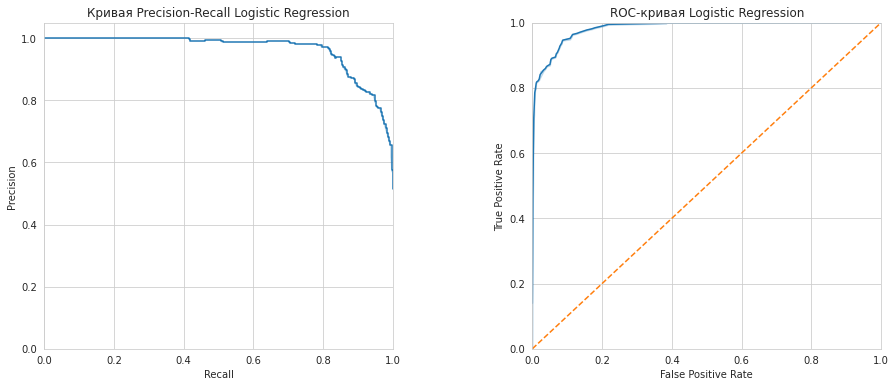

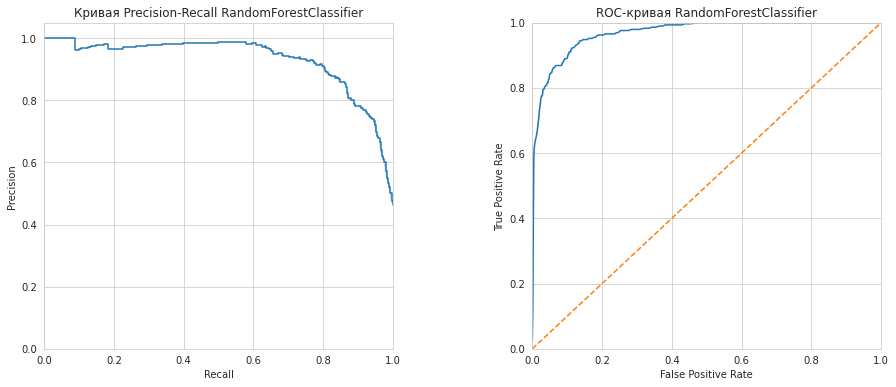

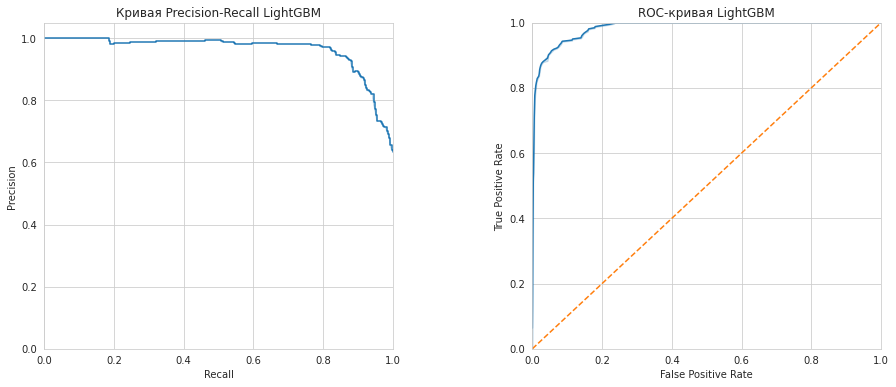

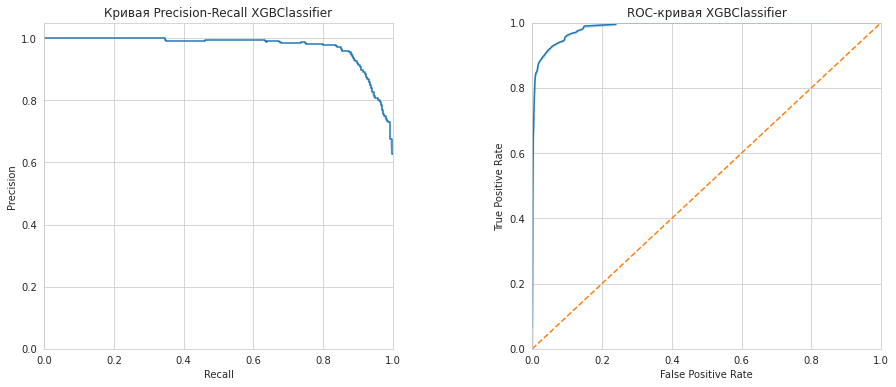

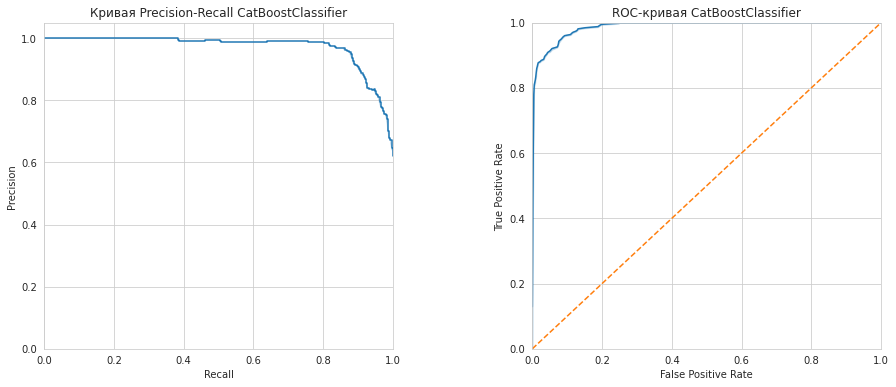

In [39]:
explorer.reporter(models, f1_score, 'f1')

In [40]:
explorer.final_report.sort_values(by='f1_score', ascending=False)

,model,f1_score,ROC-AUC
3,XGBClassifier,0.910053,0.987609
2,LightGBM,0.897887,0.983906
4,CatBoostClassifier,0.894558,0.987405
0,Logistic Regression,0.881834,0.983161
1,RandomForestClassifier,0.855124,0.968510


&#9889; **Выводы**

1. Лучший F1 Score на тестовых данных у модели XGBClassifier - 0.91.

2. Результат F1 Score около 0.9 показало еще две модели:
    - LightGBM - 0.897
    - CatBoostClassifier - 0.895
<br></br>
3. Результаты моделей хорошие, если исходить из метрики ROC-AUC у всех моделей значение выше - 0.96, на лучшей модели - 0.987, то есть предсказания моделей заметно выше случайной.
4. Дополнительные признаки - средние значения по кластерам - и тюнинг параметров моделей значительно улучшили качество по сравнению с бейзлайном: LightGBM на чистых данных показала F1 Score - 0.86, с дополнительными признаками 0.9, логистическая регрессия на чистых данных показала F1 Score - 0.84, с дополнительными признаками 0.88.

[В оглавление](#TOC)

## Рекомендации<a class='anchor' id='conclusions'></a>

Поскольку клиенты, у которых фитнес-центр ближе, которые больше вовлечены через друзей и в групповые занятия, с более длительными контрактами - в среднем, чаще ходят и лучше удерживаются, то рекомендовано продвигать как базовые - длительные абонементы, предлагать больше групповых занятий, больше использовать рефферальные программы для новых клиентов.

[В оглавление](#TOC)